In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# cnn in pytorch

/Users/seamus/opt/anaconda3/envs/ptenv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mnist_trainset = pd.read_csv("data/mnist_train.csv")
mnist_testset = pd.read_csv("data/mnist_test.csv")

In [3]:
train_labels = mnist_trainset["label"].to_numpy()
test_labels = mnist_testset["label"].to_numpy()

train_images = mnist_trainset.drop(columns=["label"]).to_numpy().reshape(60000, 28, 28) / 255.0
test_images = mnist_testset.drop(columns=["label"]).to_numpy().reshape(10000, 28, 28) / 255.0

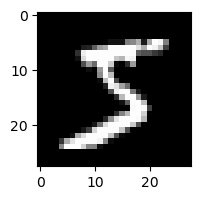

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(train_images[0], cmap="gray")

In [5]:
im_train, im_val, lab_train, lab_val = train_test_split(train_images, train_labels, test_size = 0.1)
(im_train.shape, lab_train.shape), (im_val.shape, lab_val.shape)

(((54000, 28, 28), (54000,)), ((6000, 28, 28), (6000,)))

In [6]:
#convert to torch format
im_train = im_train.reshape(54000, 1, 28, 28).astype(np.float32)
im_train = torch.from_numpy(im_train)

lab_train = torch.from_numpy(lab_train)

In [7]:
im_val = im_val.reshape(6000, 1, 28, 28).astype(np.float32)
im_val = torch.from_numpy(im_val)

lab_val = torch.from_numpy(lab_val)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), #one input channel (grayscale), 32 filters, 3x3 kernels
            nn.BatchNorm2d(32), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), #one input channel (grayscale), 32 filters, 3x3 kernels
            nn.BatchNorm2d(64), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64 * 7 * 7, out_features=64),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=64, out_features=10)
        )
    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.linear_layers(x)
        return x

In [9]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
loss = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    loss = loss.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [10]:
def train(epoch, train_losses, val_losses):
    model.train()
    tr_loss = 0

    if torch.cuda.is_available():
        im_train.cuda()
        lab_train.cuda()
        im_val.cuda()
        lab_val.cuda()
    
    optimizer.zero_grad() # clearing the gradients of the model parameters

    # predictions
    output_train = model(im_train)
    output_val = model(im_val)
    
    print("1")

    # compute loss
    loss_train = loss(output_train, lab_train)
    loss_val = loss(output_val, lab_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    print("2")

    # update all parameter weights
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()

    print("3")

    print(f"Epoch: {epoch+1}, Loss: {loss_val}")
    

In [11]:
def main():
    n_epochs = 25

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        train(epoch, train_losses, val_losses)

In [12]:
main()

1
2
